In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier#Number of trees, max features, depth, sample depth
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression#C, L1 ratio 
from sklearn.preprocessing import RobustScaler

In [2]:
#Make graphs pretty and bigger
plt.rcParams['figure.figsize'] = (10, 10)
sns.set()

In [3]:
#Load dataset
starcraft_data = pd.read_csv('wrangled_starcraft_data.csv')
starcraft_data.drop('Unnamed: 0', axis=1, inplace=True)
starcraft_data.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27.0,10.0,3000.0,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23.0,10.0,5000.0,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.000208
2,56,4,30.0,10.0,200.0,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19.0,20.0,400.0,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32.0,10.0,500.0,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


Since this is going to be a league placement classifier, a few things need to be adjusted. First, players can't be placed into Professional or Grandmaster leagues, so these will be removed. This will also handle missing data from the Professional league. Next, this model will place new accounts so they will have no play time. Also, the age and hours per week features were collected by participants submitting this information with their replays for analysis and blizzard does not track these stats anyways, so they will be removed. 

In [4]:
starcraft_data = starcraft_data.drop(starcraft_data[(starcraft_data['LeagueIndex'] == 7) |
                                                   (starcraft_data['LeagueIndex'] == 8)].index)
starcraft_data = starcraft_data.drop(['Age', 'HoursPerWeek', 'TotalHours'], axis=1)
starcraft_data.head()

,GameID,LeagueIndex,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.000208
2,56,4,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


In [5]:
starcraft_data['LeagueIndex'].unique()

array([5, 4, 3, 2, 1, 6], dtype=int64)

In [6]:
#Create training and testing split for K neighbors 
X = starcraft_data.drop(['LeagueIndex', 'GameID'], axis=1)
y = starcraft_data['LeagueIndex']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)
#Scale Data
robust = RobustScaler()
X_train = pd.DataFrame(robust.fit_transform(X_train), 
                       columns=starcraft_data.drop(['GameID', 'LeagueIndex'], axis=1).columns)
#Transform test data in the same manner as the training data. 
X_test = pd.DataFrame(robust.transform(X_test), 
                       columns=starcraft_data.drop(['GameID', 'LeagueIndex'], axis=1).columns)

In [7]:
#Create a knn model and begin feature selection
knn = KNeighborsClassifier(n_neighbors =20)
cv_scores = cross_val_score(knn, X_train, y_train, cv=5)
print('Mean score {}'.format(np.mean(cv_scores)))

Mean score 0.3511021505376344


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [8]:
#Drop column containing mostly zeroes
X_train_test = X_train.drop('ComplexUnitsMade', axis=1)
cv_scores = cross_val_score(knn, X_train_test, y_train, cv=5)
print('Mean score {}'.format(np.mean(cv_scores)))

Mean score 0.3430286738351255


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [9]:
#Drop additional less important columns 
X_train_test = X_train.drop(['ComplexUnitsMade', 'UniqueHotkeys'], axis=1)
cv_scores = cross_val_score(knn, X_train_test, y_train, cv=5)
print('Mean score {}'.format(np.mean(cv_scores)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Mean score 0.3615917236884979


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Seems that dropping features doesn't have a huge impact, so we will keep them all. 

In [10]:
#Create new model without n_neighbors defined and gridsearch
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 50)}
knn_gs = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc_ovr')
knn_gs.fit(X_train, y_train)
print('Best parameter for n_neighbors is {}'.format(knn_gs.best_params_['n_neighbors']))
print('Scoring {}'.format(knn_gs.best_score_))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWa

Best parameter for n_neighbors is 49
Scoring 0.7584898859110507


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


This tells us the best value is 49 for number of neighbors, so let's make this model.

In [11]:
knn_final = KNeighborsClassifier(n_neighbors=49)
knn_final.fit(X_train, y_train)
knn_final.score(X_test, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


0.3808948004836759

In [12]:
#Create Logisitic Regression model and feature search
log = LogisticRegression(solver='newton-cg')
cv_scores = cross_val_score(log, X_train, y_train, cv=5)
print('Mean score {}'.format(np.mean(cv_scores)))

Mean score 0.38539996741609645


In [13]:
X_train_test = X_train.drop('ComplexUnitsMade', axis=1)
cv_scores = cross_val_score(log, X_train_test, y_train, cv=5)
print('Mean score {}'.format(np.mean(cv_scores)))

Mean score 0.38903144346692736


In [14]:
X_train_test = X_train.drop(['ComplexUnitsMade', 'UniqueHotkeys', 'UniqueUnitsMade'], axis=1)
cv_scores = cross_val_score(log, X_train_test, y_train, cv=5)
print('Mean score {}'.format(np.mean(cv_scores)))

Mean score 0.3922531769305963


Again, limiting features make no significant difference so all features will be used.

In [15]:
#Create new model without and gridsearch
log_final = LogisticRegression(solver='newton-cg')
param_grid = {'C':np.logspace(-4, 4, 10), 'penalty': ['l1', 'l2']}
log_gs = GridSearchCV(log, param_grid, cv=5, scoring='roc_auc_ovr')
log_gs.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
Val

GridSearchCV(cv=5, estimator=LogisticRegression(solver='newton-cg'),
             param_grid={'C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc_ovr')

In [16]:
print('Best parameter for n_neighbors is {}'.format(log_gs.best_params_))
print('Scoring {}'.format(log_gs.best_score_))

Best parameter for n_neighbors is {'C': 0.3593813663804626, 'penalty': 'l2'}
Scoring 0.7833581256013766


In [17]:
log_final = LogisticRegression(C=166.8, penalty='l2', solver='newton-cg')
log_final.fit(X_train, y_train)
log_final.score(X_test, y_test)

0.3978234582829504

This model improves a little bit upon our nearest neighbors model. Lets try a Random Forest Model now. 

In [18]:
#Split data again, but don't scale
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X, y, test_size=0.25, random_state=10)

In [19]:
tree = RandomForestClassifier()
cv_scores = cross_val_score(tree, X_train, y_train, scoring='accuracy', cv=5)
print('Mean score {}'.format(np.mean(cv_scores)))

Mean score 0.38982323232323235


In [20]:
param_grid = { 
    'n_estimators': [10, 100, 200, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1,3,5,7,9],
}
tree_gs = GridSearchCV(tree, param_grid, cv=5, scoring='roc_auc_ovr')
tree_gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 3, 5, 7, 9],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [10, 100, 200, 500, 1000]},
             scoring='roc_auc_ovr')

In [21]:
print('Best parameter for n_neighbors is {}'.format(tree_gs.best_params_))
print('Scoring {}'.format(tree_gs.best_score_))

Best parameter for n_neighbors is {'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 500}
Scoring 0.7873769941446591


In [22]:
tree_final = RandomForestClassifier(max_features='auto', max_depth=9, n_estimators=500)
tree_final.fit(X_train, y_train)
tree_final.score(X_test, y_test)
y_pred = tree_final.predict(X_test)

In [23]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, tree_final.predict(X_test))

0.3696847059911832

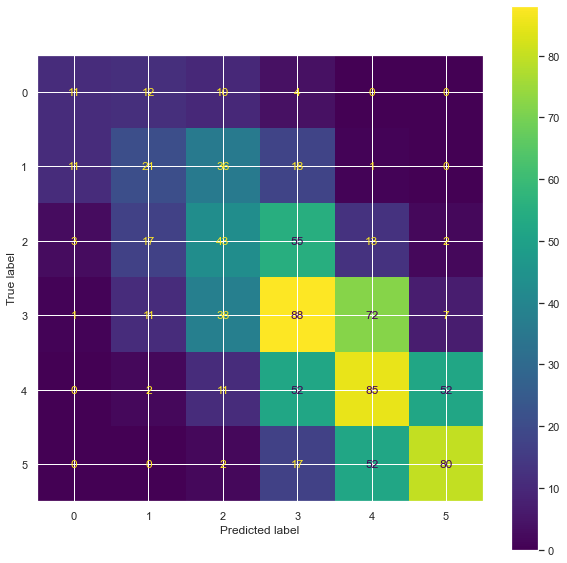

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, tree_final.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [25]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred, squared=False)

1.022716585387468

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.42      0.30      0.35        37
           2       0.33      0.24      0.28        87
           3       0.31      0.32      0.32       133
           4       0.38      0.41      0.39       217
           5       0.38      0.42      0.40       202
           6       0.57      0.53      0.55       151

    accuracy                           0.40       827
   macro avg       0.40      0.37      0.38       827
weighted avg       0.40      0.40      0.40       827



Let's now simplify the model by making a smurf detector. Leagues 1-3 will be labeled as low and leagues 5-6 will be labelled as high. League 4 will be omitted to both simplify the model more and this isn't a common area for smurfing. 

In [27]:
#Omit the 4th League
starcraft_data = starcraft_data.drop(starcraft_data[(starcraft_data['LeagueIndex'] == 4)].index)
starcraft_data['LeagueIndex'].unique()

array([5, 3, 2, 1, 6], dtype=int64)

In [28]:
starcraft_data['Level'] = np.where(((starcraft_data['LeagueIndex'] == 1) |
                     (starcraft_data['LeagueIndex'] == 2) |
                     (starcraft_data['LeagueIndex'] == 3)), 0 , 1)#Low is 0, high is 1
starcraft_data.head()

,GameID,LeagueIndex,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed,Level
0,52,5,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000,1
1,55,5,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.000208,1
3,57,3,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384,0
4,58,3,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019,0
5,60,2,44.4570,0.000978,0.000255,2,0.000000,0.000000,0.002425,76.4405,98.7719,3.0965,16,0.000372,6,0.0,0.000000,0


In [29]:
#Since we have a new targer variable, we can drop the League Index. 
#We can also drop game id while we're at it. 
no_league = starcraft_data.drop(['LeagueIndex', 'GameID'], axis=1)
no_league.head()

,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed,Level
0,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000,1
1,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.000208,1
3,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384,0
4,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019,0
5,44.4570,0.000978,0.000255,2,0.000000,0.000000,0.002425,76.4405,98.7719,3.0965,16,0.000372,6,0.0,0.000000,0


In [31]:
X = no_league.drop('Level', axis=1)
y = no_league['Level']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)
#Scale data same as before
robust = RobustScaler()
X_train = pd.DataFrame(robust.fit_transform(X_train), 
                       columns=no_league.drop('Level', axis=1).columns)
#Transform test data in the same manner as the training data. 
X_test = pd.DataFrame(robust.transform(X_test), 
                       columns=no_league.drop('Level', axis=1).columns)

In [32]:
knn = KNeighborsClassifier(n_neighbors=20)
cv_scores = cross_val_score(knn, X_train, y_train, cv=5)
print('Mean score {}'.format(np.mean(cv_scores)))

Mean score 0.8379679144385026


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [33]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 50)}
knn_gs = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc_ovr')
knn_gs.fit(X_train, y_train)
print('Best parameter for n_neighbors is {}'.format(knn_gs.best_params_['n_neighbors']))
print('Scoring {}'.format(knn_gs.best_score_))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWa

Best parameter for n_neighbors is 47
Scoring 0.9213965987363972


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.82      0.82      0.82       268
           1       0.86      0.86      0.86       356

    accuracy                           0.84       624
   macro avg       0.84      0.84      0.84       624
weighted avg       0.84      0.84      0.84       624



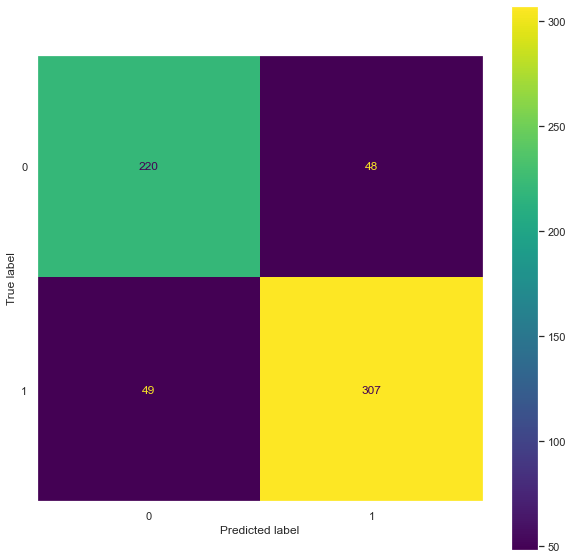

In [34]:
knn_final = KNeighborsClassifier(n_neighbors=41)
knn_final.fit(X_train, y_train)
y_pred = knn_final.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.grid(False)
print(classification_report(y_test, y_pred))

In [35]:
balanced_accuracy_score(y_test, y_pred)

0.8416275364749288

In [36]:
log = LogisticRegression()
cv_scores = cross_val_score(log, X_train, y_train, cv=5)
print('Mean score {}'.format(np.mean(cv_scores)))

Mean score 0.8497326203208557


In [37]:
log_final = LogisticRegression()
param_grid = {'C':np.logspace(-4, 4, 10), 'penalty': ['l1', 'l2']}
log_gs = GridSearchCV(log, param_grid, cv=5, scoring='roc_auc')
log_gs.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
Val

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [38]:
print('Best parameter for n_neighbors is {}'.format(log_gs.best_params_))
print('Scoring {}'.format(log_gs.best_score_))

Best parameter for n_neighbors is {'C': 0.3593813663804626, 'penalty': 'l2'}
Scoring 0.9276963349846014


              precision    recall  f1-score   support

           0       0.82      0.86      0.84       268
           1       0.89      0.85      0.87       356

    accuracy                           0.86       624
   macro avg       0.85      0.86      0.86       624
weighted avg       0.86      0.86      0.86       624



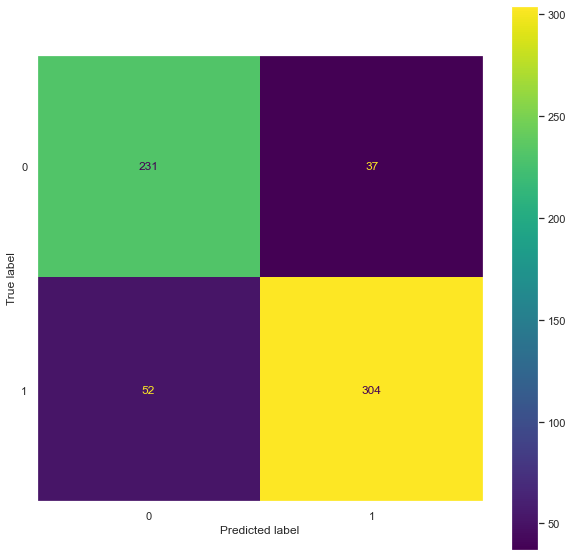

In [39]:
log_final = LogisticRegression(C=0.359, penalty='l2', solver='newton-cg')
log_final.fit(X_train, y_train)
y_pred = log_final.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.grid(False)
print(classification_report(y_test, y_pred))

In [40]:
balanced_accuracy_score(y_test, log_final.predict(X_test))

0.8579364413885628

In [41]:
tree = RandomForestClassifier()
cv_scores = cross_val_score(tree, X_train, y_train, scoring='accuracy', cv=5)
print('Mean score {}'.format(np.mean(cv_scores)))

Mean score 0.8561497326203208


In [42]:
param_grid = { 
    'n_estimators': [10, 100, 200, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1,3,5,7,9],
}
tree_gs = GridSearchCV(tree, param_grid, cv=5, scoring='roc_auc')
tree_gs.fit(X_train, y_train)
print('Best parameter for n_neighbors is {}'.format(tree_gs.best_params_))
print('Scoring {}'.format(tree_gs.best_score_))

Best parameter for n_neighbors is {'max_depth': 7, 'max_features': 'log2', 'n_estimators': 1000}
Scoring 0.9281373323956099


              precision    recall  f1-score   support

           0       0.84      0.85      0.84       268
           1       0.88      0.88      0.88       356

    accuracy                           0.87       624
   macro avg       0.86      0.86      0.86       624
weighted avg       0.87      0.87      0.87       624



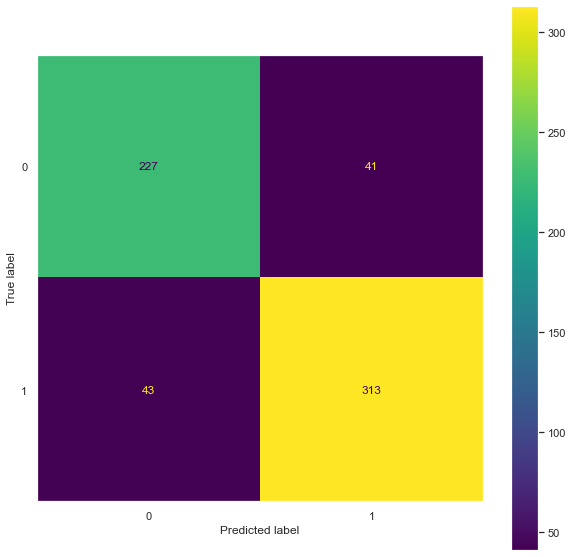

In [43]:
tree_final = RandomForestClassifier(max_features='sqrt', max_depth=7, n_estimators=500)
tree_final.fit(X_train, y_train)
y_pred = tree_final.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.grid(False)
print(classification_report(y_test, y_pred))

In [44]:
balanced_accuracy_score(y_test, y_pred)

0.8631142042596008

We want a high recall for this smurf detection. The reason is, if someone is labelled a smurf it's not a big deal. The system will adjust as send them back down based on their win/lose raito. Also, no one complains about some extra boost unless they are a smurf. We want to find as many true smurfs as possible so they can get out of their smurfing league. Their win/lose ratio will then hopefully keep them out. 

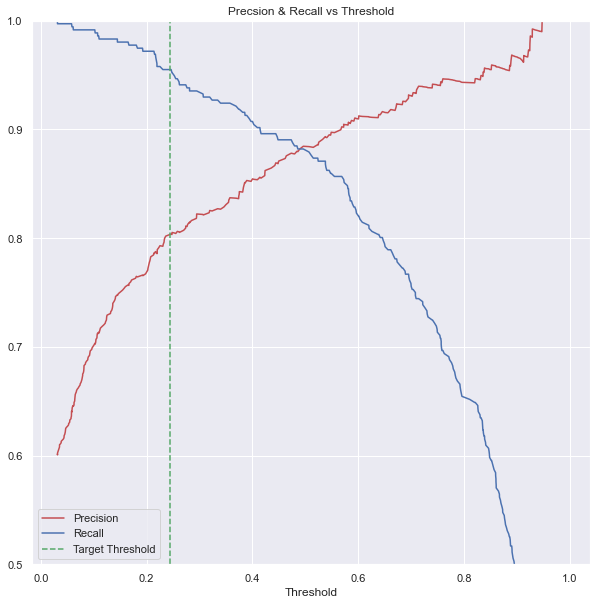

In [45]:
#Let's go with the Forest model since it has a slightly higher recall
from sklearn.metrics import precision_recall_curve
precision, recall, threshold = precision_recall_curve(y_test, tree_final.predict_proba(X_test)[:, 1])
plt.plot(threshold, precision[:-1], color='r', label='Precision')
plt.plot(threshold, recall[:-1], color='b', label='Recall')
plt.title('Precsion & Recall vs Threshold')
plt.xlabel('Threshold')
plt.ylim([0.5, 1])
plt.axvline(x=0.245, label='Target Threshold', color='g', linestyle='--')
plt.legend(loc='lower left')

We pick the above threshold as we want to maximize recall. At 95% recall, we still have decent precision at 80%. After this point, precision drops off significantly. 

In [46]:
#Find where in recall that its value is ~95%. Use this index to get target threshold
idx = np.abs(recall - 0.95).argmin()
tar_thres = threshold[idx]
tar_thres

0.25253639700772296

              precision    recall  f1-score   support

           0       0.91      0.69      0.79       268
           1       0.80      0.95      0.87       356

    accuracy                           0.84       624
   macro avg       0.86      0.82      0.83       624
weighted avg       0.85      0.84      0.83       624



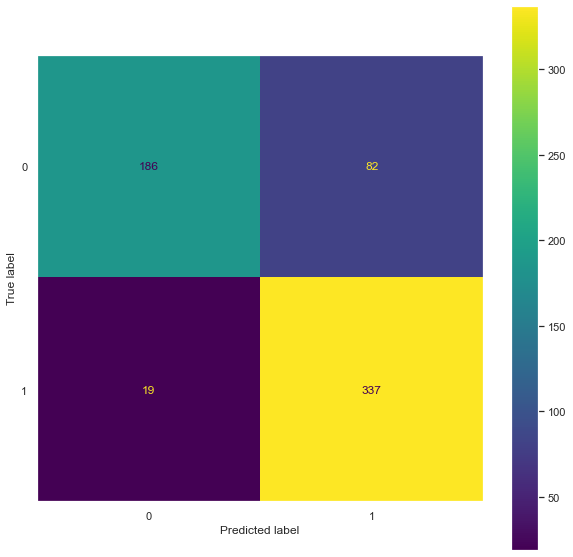

In [47]:
#Using this new threshold and the prediction probabilites provided by our model, 
#we will relabel our predictions.
y_probs = tree_final.predict_proba(X_test)
new_y_pred = np.where(y_probs[:, 1] > tar_thres, 1, 0)
#use these new predictios to make a confusion matrix and classification report
cm = confusion_matrix(y_test, new_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.grid(False)
print(classification_report(y_test, new_y_pred))

In [48]:
#Find all misclassified indexes and make a new dataframe
misclass_indexes = []
for idx, i in enumerate(new_y_pred):
    if i != y_test.iloc[idx]:
        misclass_indexes.append(y_test.index[idx])#Get index value, not index number
misclass_df = no_league.loc[misclass_indexes, :]

In [49]:
#See if any obvious things can be seen from comparing the df's 
misclass_df.describe()

,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed,Level
count,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,104.615459,0.002823,0.000307,4.009901,0.000065,0.000359,0.003160,40.911707,66.430857,5.675042,21.376238,0.001041,6.198020,0.000061,0.000133,0.188119
std,28.619332,0.002915,0.000167,2.574859,0.000098,0.000363,0.000686,11.662404,12.815587,1.727971,6.974025,0.000465,1.714758,0.000112,0.000239,0.392756
min,60.115800,0.000156,0.000031,0.000000,0.000000,0.000012,0.001537,17.848100,39.070400,2.454000,7.000000,0.000427,3.000000,0.000000,0.000000,0.000000
25%,86.020800,0.001037,0.000185,2.000000,0.000000,0.000129,0.002666,32.073300,57.429500,4.331800,16.000000,0.000705,5.000000,0.000000,0.000000,0.000000
50%,100.035600,0.001992,0.000285,4.000000,0.000021,0.000240,0.003167,38.788800,65.411800,5.622400,22.000000,0.000919,6.000000,0.000000,0.000012,0.000000
75%,118.551000,0.003263,0.000416,5.000000,0.000090,0.000479,0.003518,50.007100,73.664300,6.493200,26.000000,0.001274,7.000000,0.000096,0.000165,0.000000
max,220.069200,0.018981,0.000789,10.000000,0.000494,0.002031,0.004733,72.646200,114.473700,12.157900,48.000000,0.003094,10.000000,0.000497,0.001467,1.000000


In [50]:
starcraft_data.drop(['GameID', 'LeagueIndex'], axis=1).describe()

,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed,Level
count,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000
mean,116.356903,0.004232,0.000367,4.392943,0.000096,0.000381,0.003450,40.856188,64.350068,5.276455,22.069366,0.001036,6.523256,0.000058,0.000141,0.572173
std,50.964837,0.005018,0.000213,2.362710,0.000167,0.000360,0.001014,18.153213,20.451738,1.532955,7.422794,0.000531,1.870470,0.000109,0.000265,0.494863
min,22.059600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000679,6.666700,24.632600,2.038900,5.000000,0.000077,2.000000,0.000000,0.000000,0.000000
25%,78.067350,0.001223,0.000198,3.000000,0.000000,0.000138,0.002712,28.776000,49.604425,4.262850,16.000000,0.000681,5.000000,0.000000,0.000000,0.000000
50%,108.514800,0.002533,0.000352,4.000000,0.000040,0.000278,0.003388,36.641950,60.607550,5.092650,22.000000,0.000915,6.000000,0.000000,0.000018,1.000000
75%,145.530000,0.005314,0.000501,6.000000,0.000117,0.000508,0.004067,48.677950,75.407625,6.045050,27.000000,0.001268,8.000000,0.000083,0.000182,1.000000
max,389.831400,0.043088,0.001376,10.000000,0.003019,0.003030,0.007191,237.142900,176.372100,18.558100,56.000000,0.005149,13.000000,0.000902,0.003084,1.000000


In [51]:
prob_df = pd.DataFrame(y_test)
prob_df['prob_is_smurf'] = y_probs[:, 1]

In [52]:
prob_df.sort_values('prob_is_smurf', ascending=True)

,Level,prob_is_smurf
486,0,0.010862
573,0,0.012762
72,0,0.013049
3040,0,0.013160
6,0,0.013626
...,...,...
747,1,0.988640
2487,1,0.988808
2514,1,0.988847
464,1,0.989605


In [53]:
prob_df = misclass_df.merge(prob_df['prob_is_smurf'], how='right', left_index=True, right_index=True)

In [54]:
prob_df.sort_values('prob_is_smurf', ascending=True)

,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed,Level,prob_is_smurf
486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010862
573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.012762
72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.013049
3040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.013160
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.013626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.988640
2487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.988808
2514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.988847
464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.989605


In [55]:
#Redefine training and test sets without scaling
X = no_league.drop('Level', axis=1)
y = no_league['Level']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)
full_test_df = X_test.copy(deep=True)
full_test_df['y_true'] = y_test
full_test_df['y_pred_proba'] = y_probs[:, 1]

In [56]:
full_test_df

,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed,y_true,y_pred_proba
677,101.0706,0.002351,0.000458,5,0.000458,0.000265,0.004039,25.7964,63.7731,4.2418,24,0.001170,7,0.0,0.000000,1,0.841003
1982,77.3160,0.002594,0.000620,10,0.000165,0.000393,0.003700,39.0252,63.3855,3.4246,26,0.000848,9,0.0,0.000372,1,0.754709
1350,85.2954,0.000980,0.000091,0,0.000000,0.000433,0.001686,49.5890,83.6216,8.8514,12,0.000820,4,0.0,0.000000,0,0.062805
3059,112.0380,0.002276,0.000251,6,0.000133,0.000340,0.003325,40.2321,58.8444,5.4356,15,0.001936,7,0.0,0.000000,1,0.796430
543,143.6058,0.005499,0.000669,1,0.000000,0.000086,0.004723,24.1835,43.6530,4.4977,12,0.000798,4,0.0,0.000086,1,0.906688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,78.8250,0.000045,0.000205,3,0.000000,0.000637,0.003185,45.6978,72.9714,4.6786,7,0.000341,4,0.0,0.000000,0,0.171729
3213,97.7454,0.003015,0.000296,3,0.000205,0.000330,0.002606,38.2105,84.2969,6.3144,20,0.001434,6,0.0,0.000000,0,0.284944
15,81.7722,0.002333,0.000430,4,0.000000,0.000249,0.002900,45.1654,64.7500,4.5312,15,0.001246,6,0.0,0.000227,1,0.476379
3155,25.4442,0.000385,0.000160,3,0.000192,0.000064,0.000994,113.2000,165.1613,4.3548,7,0.000385,2,0.0,0.000000,0,0.064325


In [57]:
full_test_df[full_test_df['y_true'] ==1].sort_values('y_pred_proba', ascending=True).head(20)

,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed,y_true,y_pred_proba
2334,60.7074,0.001067,0.000243,6,0.000112,0.000393,0.002453,72.6462,84.0000,4.1298,20,0.000637,5,0.000000,0.000000,1,0.031511
1683,60.1158,0.000495,0.000237,4,0.000000,0.000215,0.002065,52.5895,88.7083,5.4375,11,0.000473,4,0.000000,0.000172,1,0.058168
969,90.2280,0.001482,0.000107,0,0.000021,0.000172,0.002684,50.6129,76.1600,5.8720,15,0.001074,6,0.000000,0.000000,1,0.061077
788,67.8690,0.000663,0.000282,10,0.000012,0.000061,0.003512,50.1754,73.6643,3.4685,16,0.000933,5,0.000049,0.000037,1,0.102202
27,74.1174,0.000875,0.000205,6,0.000018,0.000045,0.003518,46.4122,71.8173,3.7944,34,0.000929,5,0.000000,0.000000,1,0.107394
2580,79.0356,0.001025,0.000247,8,0.000104,0.000237,0.002505,35.7414,78.4848,5.6212,26,0.000750,6,0.000000,0.000000,1,0.109546
659,78.8736,0.001289,0.000126,3,0.000000,0.000210,0.003210,43.7368,74.0437,4.2183,10,0.000701,6,0.000084,0.000070,1,0.144812
3203,66.1536,0.000805,0.000383,4,0.000000,0.000115,0.003028,38.9554,80.1772,3.9430,15,0.000901,6,0.000000,0.000077,1,0.165191
1177,60.6252,0.001974,0.000351,5,0.000187,0.000070,0.003295,52.0285,68.0426,3.1950,23,0.000923,5,0.000000,0.000000,1,0.180666
855,82.0194,0.002442,0.000306,3,0.000000,0.000225,0.003106,55.6040,75.3026,4.2533,23,0.000736,9,0.000215,0.000296,1,0.192428


In [58]:
full_test_df[full_test_df['y_true'] ==0].sort_values('y_pred_proba', ascending=False).head(20)

,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed,y_true,y_pred_proba
1702,127.0134,0.003093,0.000441,8,0.000144,0.000638,0.004136,43.7908,54.7130,4.9283,35,0.002131,7,0.000207,0.000405,0,0.947596
2598,142.7670,0.005962,0.000569,5,0.000000,0.000300,0.004015,34.4120,52.9403,5.3172,22,0.001168,7,0.000000,0.000165,0,0.929481
2397,157.3410,0.002981,0.000640,2,0.000000,0.000530,0.004717,23.6440,39.0705,5.7050,26,0.001921,7,0.000000,0.000000,0,0.925052
2519,136.1160,0.003263,0.000515,2,0.000041,0.000669,0.003552,31.0233,54.0406,6.5362,17,0.000947,7,0.000494,0.000525,0,0.924754
2097,140.7960,0.001992,0.000242,3,0.000091,0.000717,0.004528,27.3389,44.8267,5.0783,34,0.000928,6,0.000000,0.000000,0,0.920834
484,220.0692,0.013082,0.000230,5,0.000090,0.000064,0.004246,29.3897,42.5422,6.6747,22,0.001355,7,0.000179,0.000678,0,0.912980
2915,115.2984,0.006638,0.000789,6,0.000026,0.000315,0.004009,34.4605,57.4295,3.8656,19,0.000684,6,0.000000,0.000145,0,0.889302
1180,128.6142,0.003892,0.000569,3,0.000180,0.000180,0.002754,24.7033,55.6087,7.3804,16,0.000569,4,0.000000,0.000030,0,0.888409
1857,118.5510,0.003857,0.000495,6,0.000059,0.000153,0.003999,41.3728,58.6667,4.7994,27,0.000743,8,0.000000,0.000059,0,0.886208
2135,192.3036,0.008345,0.000614,10,0.000000,0.000128,0.003635,27.7447,39.0704,7.6197,16,0.000794,3,0.000000,0.000000,0,0.851816
